# <span style="color:#4174B9">Baseball Statistics</span>

Baseball statistics are used in evaluating a player's and/or a team's performance. Since the flow of a baseball game has natural breaks to it, and normally players act individually rather than performing in clusters, the sport lends itself to easy record-keeping and statistics. Statistics have been kept for professional baseball since the creation of the National League and American League, now part of Major League Baseball. The importance of statistics in baseball increased with the advent of free agency in 1974. Statistics beacame vital information in determining individual salary, with the free agent market clearly setting what each player should be paid for his given statistics.

The following analysis is based on baseball data made available by Sean Lahman, an award-winning database journalist and author. The data can be downloaded from his [website](http://www.seanlahman.com/baseball-archive/statistics/). Let us start by exploring the player salararies.

## <span style="color:#117A65">Analysis of MLB payrolls</span>

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib as mpl
import seaborn as sns

# Set display properties
%pylab inline
sns.set_style('white')
pd.options.display.max_rows = 8
pd.options.display.max_columns = 15

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read data from csv file into pandas dataframe
def read_csv(filename):
    # The argument to this function is the filename of csv file
    path = './baseballdatabank-master/core/'
    data = pd.read_csv(path + filename, sep=',', keep_default_na=False, na_values=[''])
    print filename, 'has', data.shape[0], 'rows and', data.shape[1], 'columns'
    return data

In [3]:
# Format summary statistics of salary
def format_salary(x):
    return r'$%1.2fM' % (x*1e-6)

In [4]:
# Read in the salary details
salaries = read_csv('Salaries.csv')

Salaries.csv has 25575 rows and 5 columns


In [5]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25575 entries, 0 to 25574
Data columns (total 5 columns):
yearID      25575 non-null int64
teamID      25575 non-null object
lgID        25575 non-null object
playerID    25575 non-null object
salary      25575 non-null int64
dtypes: int64(2), object(3)
memory usage: 999.1+ KB


In [6]:
print salaries.head(), '\n'
print 'Data from', salaries.yearID.min(), 'to', salaries.yearID.max()

   yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000
3    1985    ATL   NL   campri01  633333
4    1985    ATL   NL  ceronri01  625000 

Data from 1985 to 2015


The data contains salaries of MLB players from 1985 to 2015 along with the team which hired them. Let us look at the distribution of salaries over time.

### Distribution of players' salary over time

In [7]:
# Salary Stats
def yearly_stats(groupby):
    # The argument to this function is the column name by which data needs to be grouped: ['playerID', 'teamID']
    cols = ['yearID']
    cols.append(groupby)
    s = salaries.groupby(cols).sum().reset_index()
    s = s.groupby('yearID').agg({"salary": {"max_salary" : np.max,
                                            "avg_salary" : np.mean,
                                            "median_salary" : np.median,
                                            "min_salary" : np.min}})
    s.columns = s.columns.get_level_values(1)
    return s

In [8]:
yearly_salary_stats = yearly_stats('playerID')
yearly_payroll_stats = yearly_stats('teamID')

In [9]:
# Format salary labels to make them concise in plots
def millions(x, pos):
    # The two args are the value and tick position
    return format_salary(x)

formatter = FuncFormatter(millions)

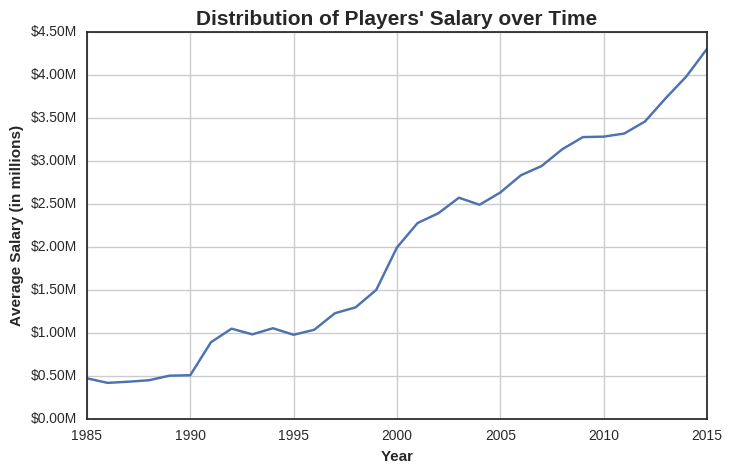

In [10]:
# Plot average annual salary vs year
f, ax = plt.subplots()
f.set_size_inches((8,5))

plt.plot(yearly_salary_stats.index, yearly_salary_stats.avg_salary, label='Avg. Player Salary')
ax.yaxis.set_major_formatter(formatter)

plt.title("Distribution of Players' Salary over Time", fontsize=15, weight='bold')
plt.xlabel("Year", weight='bold')
plt.ylabel("Average Salary (in millions)", weight='bold')

plt.grid()

Average yearly salary of a player has an increasing trend with time. There are some up's and down's which coincide with some of the major events in baseball history. For example, the abrupt increase from 1990 to 1991 coincides with [1990 Major League Baseball lockout](https://en.wikipedia.org/wiki/1990_Major_League_Baseball_lockout) which was resolved by raising minimum major league salary from \$68,000 to \$100,000. The period 1993-95 has a non-increasing trend. During this period, a dispute played out between the players and the ownership regarding the proposal of salary-cap which led to the [1994–95 Major League Baseball strike](https://en.wikipedia.org/wiki/1994%E2%80%9395_Major_League_Baseball_strike). As a result of this strike, the 1994 World series was cancelled. Post-strike years has an ever increasing trend. There is a small dip in year 2004 which coincides with the announcement of a [new drug policy](https://en.wikipedia.org/wiki/List_of_Major_League_Baseball_players_suspended_for_performance-enhancing_drugs) in Jan 2004 which led to suspension of many MLB players for the use of performance-enhancing drugs.

In [11]:
yearly_salary_stats.avg_salary.describe().iloc[1:].apply(format_salary)

mean    $1.98M
std     $1.22M
min     $0.42M
25%     $0.98M
50%     $2.00M
75%     $3.04M
max     $4.30M
Name: avg_salary, dtype: object

The average player-salary has increased by 800% from \$0.5M in 1985 to \$4.3M in 2015. Let us look at the distribution of amount spent by teams on payrolls over time.

### Distribution of Team payrolls over time

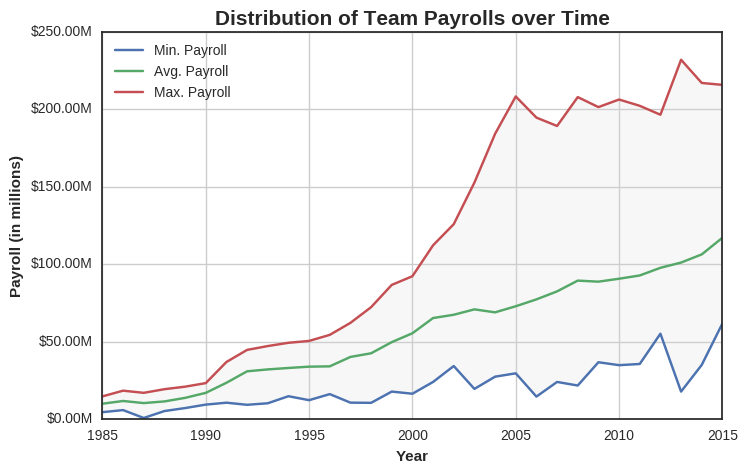

In [12]:
# Plot average annual payroll vs year
f, ax = plt.subplots()
f.set_size_inches((8,5))

plt.plot(yearly_payroll_stats.index, yearly_payroll_stats.min_salary, label='Min. Payroll')
plt.plot(yearly_payroll_stats.index, yearly_payroll_stats.avg_salary, label='Avg. Payroll')
plt.plot(yearly_payroll_stats.index, yearly_payroll_stats.max_salary, label='Max. Payroll')

ax.fill_between(yearly_payroll_stats.index, yearly_payroll_stats.min_salary,
                yearly_payroll_stats.max_salary, alpha=0.2, color='0.85')
ax.yaxis.set_major_formatter(formatter)

plt.title("Distribution of Team Payrolls over Time", fontsize=15, weight='bold')
plt.xlabel("Year", weight='bold')
plt.ylabel("Payroll (in millions)", weight='bold')
plt.legend(loc='best')

plt.grid()

Team payrolls have an interesting trend over time. The maximum amount spent on payrolls increases more steeply than the minimum amount. During 1985-90, the increase is very low, and the range of salaries is almost constant. From 1991 to 2005 the maximum amount spent on payroll increased steeply while increase in minimum amount spent is very low. Moreover, this increasing trend in maximum payroll is absent after 2005. Let us look at the spread of payroll amounts for individual teams.

In [13]:
yearly_payroll = salaries.groupby(['teamID', 'yearID'], as_index=False).sum()

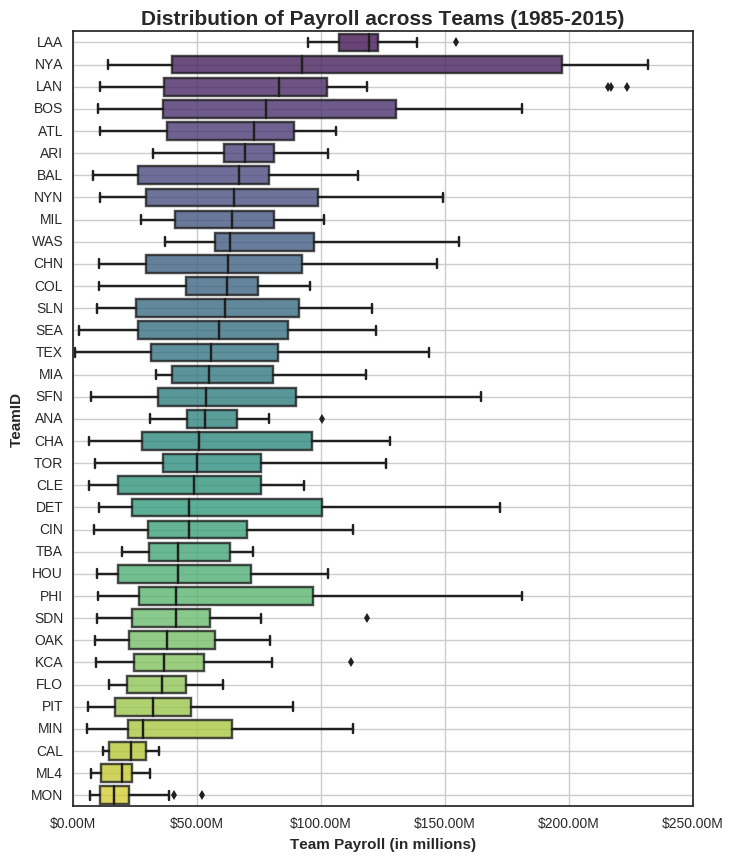

In [14]:
plt.figure(figsize=(8,10))

order = yearly_payroll.groupby('teamID').median().sort_values(by='salary', ascending=False).index
g = sns.boxplot(data=yearly_payroll, x='salary', y='teamID', order=order, palette='viridis')

plt.setp(g.artists, alpha=0.8)
g.xaxis.set_major_formatter(formatter)
g.set_title("Distribution of Payroll across Teams (1985-2015)", fontsize=15, weight='bold')
g.set_xlabel("Team Payroll (in millions)", weight='bold')
g.set_ylabel("TeamID", weight='bold')

g.grid()

The boxplot clearly shows that not all teams spend equally on their payrolls. For example, the minimum amount spent by Los Angeles Angels of Anaheim (LAA) is higher than the median amount of all individual teams. A possible explanation to the observed trend can be that some teams can spend huge amounts on payroll to hire best talent while others cannot support the best players financially. How can we test this hypothesis? If our hypothesis is true then the teams payroll should translate to teams performance in regular season and post-season. We test our hypothesis by performing regression analysis relating regular season and post-season success to team payroll.

In [15]:
# Read in team details
teams = read_csv('Teams.csv')
teams_post = read_csv('SeriesPost.csv')

Teams.csv has 2805 rows and 48 columns
SeriesPost.csv has 307 rows and 9 columns


In [16]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805 entries, 0 to 2804
Data columns (total 48 columns):
yearID            2805 non-null int64
lgID              2805 non-null object
teamID            2805 non-null object
franchID          2805 non-null object
divID             1288 non-null object
Rank              2805 non-null int64
G                 2805 non-null int64
Ghome             2406 non-null float64
W                 2805 non-null int64
L                 2805 non-null int64
DivWin            1260 non-null object
WCWin             624 non-null object
LgWin             2777 non-null object
WSWin             2448 non-null object
R                 2805 non-null int64
AB                2805 non-null int64
H                 2805 non-null int64
2B                2805 non-null int64
3B                2805 non-null int64
HR                2805 non-null int64
BB                2805 non-null int64
SO                2685 non-null float64
SB                2661 non-null float64
CS    

In [17]:
teams.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,...,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NA,BS1,BNA,NaN,3,31,...,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NA,CH1,CNA,NaN,2,28,...,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1
2,1871,NA,CL1,CFC,NaN,8,29,...,National Association Grounds,NaN,96,100,CLE,CL1,CL1
3,1871,NA,FW1,KEK,NaN,7,19,...,Hamilton Field,NaN,101,107,KEK,FW1,FW1
4,1871,NA,NY2,NNA,NaN,5,33,...,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2


In [18]:
teams = pd.merge(teams, yearly_payroll, on=['teamID', 'yearID'], how='left')

In [19]:
teams['win_percent'] = (teams.W / teams.G) * 100

In [20]:
teams.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,...,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro,salary,win_percent
0,1871,NA,BS1,BNA,NaN,3,31,...,103,98,BOS,BS1,BS1,NaN,64.516129
1,1871,NA,CH1,CNA,NaN,2,28,...,104,102,CHI,CH1,CH1,NaN,67.857143
2,1871,NA,CL1,CFC,NaN,8,29,...,96,100,CLE,CL1,CL1,NaN,34.482759
3,1871,NA,FW1,KEK,NaN,7,19,...,101,107,KEK,FW1,FW1,NaN,36.842105
4,1871,NA,NY2,NNA,NaN,5,33,...,90,88,NYU,NY2,NY2,NaN,48.484848


In [21]:
teams_post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 9 columns):
yearID          307 non-null int64
round           307 non-null object
teamIDwinner    307 non-null object
lgIDwinner      307 non-null object
teamIDloser     307 non-null object
lgIDloser       307 non-null object
wins            307 non-null int64
losses          307 non-null int64
ties            307 non-null int64
dtypes: int64(4), object(5)
memory usage: 21.7+ KB


In [22]:
teams_post.head()

,yearID,round,teamIDwinner,lgIDwinner,teamIDloser,lgIDloser,wins,losses,ties
0,1884,WS,PRO,NL,NYP,AA,3,0,0
1,1885,WS,CHC,NL,STL,AA,3,3,1
2,1886,WS,STL,AA,CHC,NL,4,2,0
3,1887,WS,DTN,NL,STL,AA,10,5,0
4,1888,WS,NYG,NL,STL,AA,6,4,0


In [23]:
games_won = teams_post.groupby(['teamIDwinner','yearID']).sum()
games_lost = teams_post.groupby(['teamIDloser','yearID']).sum()

playoffs = pd.concat([games_won, games_lost], axis=0).reset_index()
playoffs.columns = ['teamID', 'yearID', 'post_W', 'post_L', 'post_T']

playoffs['post_G'] = playoffs.post_W + playoffs.post_L + playoffs.post_T

playoffs = playoffs.groupby(['teamID', 'yearID']).sum().reset_index()

In [24]:
teams = pd.merge(teams, playoffs, on=['teamID', 'yearID'], how='left')

In [25]:
teams['post_win_percent'] = (teams.post_W / teams.post_G) *100
teams.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,...,salary,win_percent,post_W,post_L,post_T,post_G,post_win_percent
0,1871,NA,BS1,BNA,NaN,3,31,...,NaN,64.516129,NaN,NaN,NaN,NaN,NaN
1,1871,NA,CH1,CNA,NaN,2,28,...,NaN,67.857143,NaN,NaN,NaN,NaN,NaN
2,1871,NA,CL1,CFC,NaN,8,29,...,NaN,34.482759,NaN,NaN,NaN,NaN,NaN
3,1871,NA,FW1,KEK,NaN,7,19,...,NaN,36.842105,NaN,NaN,NaN,NaN,NaN
4,1871,NA,NY2,NNA,NaN,5,33,...,NaN,48.484848,NaN,NaN,NaN,NaN,NaN


In [26]:
def linear_reg(s):
    y = {'rs': 'win_percent', 'ps': 'post_win_percent'}
    t = {'rs': 'Regular Season %Wins Vs Payroll (1985-2015)', 'ps': 'Post-Season %Wins Vs Payroll (1985-2015)'}
    c = {'rs': sns.color_palette()[5], 'ps': sns.color_palette()[3]}
    
    g = sns.lmplot(data=teams, x='salary', y=y[s], size=5, aspect=1.5,
                   scatter_kws={'color': c[s]}, line_kws={'color': c[s]})

    g.fig.suptitle(t[s], fontsize=15, weight='bold')
    g.set_xlabels("Payroll (in millions)", weight='bold')
    g.set_ylabels("%Wins", weight='bold')
    sns.despine(right=False, top=False)

    mask = ~pd.isnull(teams['salary']) & ~pd.isnull(teams[y[s]])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x=teams['salary'][mask]*1e-6,
                                                                   y=teams[y[s]][mask])
    g.ax.xaxis.set_major_formatter(formatter)

    g.ax.text(0.01, 0.935,
              r"$R^2={r}$".format(r='%.2g'%r_value**2) + "\n"
              r"$r={r}, \thinspace p={p}$".format(r='%.2g'%r_value, p='%.2g'%p_value) + "\n" + 
              r"$y={m}x+{c}$".format(m=round(slope,2), c=round(intercept,2)),
              ha='left', va='top',
              transform = g.ax.transAxes, fontsize=12)

    g.ax.grid()

    g.fig.tight_layout(rect=[0, 0, 1, 0.97])

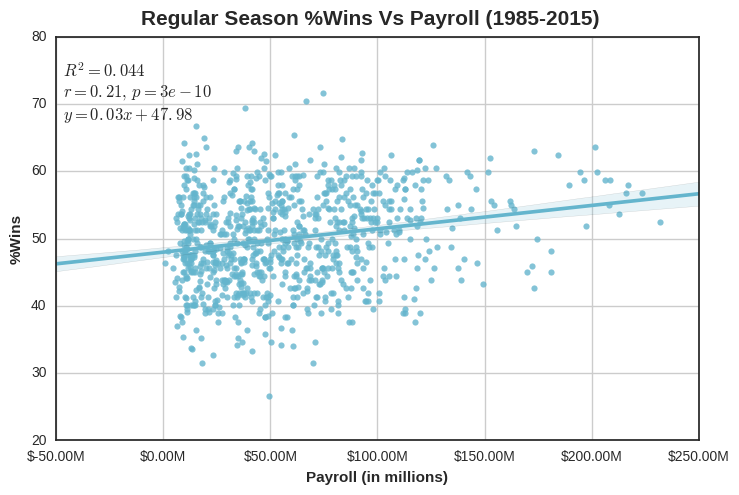

In [27]:
linear_reg('rs')

Based on the data at hand on team payrolls and regular season wins, a regression analysis relating percentage wins to team payroll suggests a positive relationship. The p-value for the slope suggests a statistically signigicant relationship. Every \$30000 spent on payroll increases regular season wins by 1%. As expected, we found a statistically significant positive relationship with $R^2$ value of 0.044. A significant positive slope from our analysis suggests that the free agency market is partly responsible for competitive imbalance in regular season.

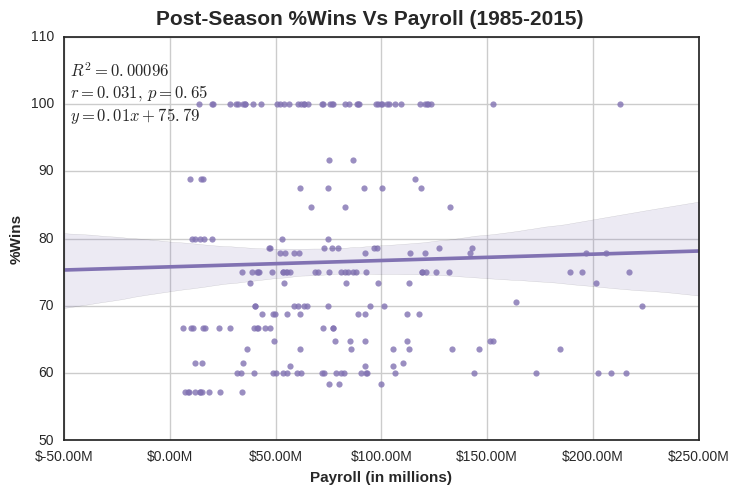

In [28]:
linear_reg('ps')

In our analysis of post-season wins, the result of the regression analysis are not as expected. The results suggests statistically insignificant relationship between percentage wins and payroll.It suggests that a short post-season is a random event in which team payroll has a neglible effect on wins. Before we proceed further with our analysis, let us summarize our finding.

The results of the regression analysis suggests that team payroll has significant impact on success in regular season due to free agency market. The ability to purchase talent in open market and a 162 game season over six months diminishes the random elements leading to expected effects of team payroll on regular season winning percentage. While conventional wisdom leads us to think that teams have the ability to "buy" championships in baseball because there is no salary-cap, our analysis does not support this claim. We did not find a statistically significant relationship between post-season wins and team payroll.

The next section aims at analyzing player statistics.

## <span style="color:#117A65">Analysis of Player Statistics</span>

In [29]:
batting = read_csv('Batting.csv')
pitching = read_csv('Pitching.csv')
fielding = read_csv('Fielding.csv')

Batting.csv has 101332 rows and 22 columns
Pitching.csv has 44139 rows and 30 columns
Fielding.csv has 170526 rows and 18 columns


In [30]:
# Add salary information to player metrics
batting = batting.merge(salaries[['playerID','salary']], on='playerID', how='left')
pitching = pitching.merge(salaries[['playerID','salary']], on='playerID', how='left')
fielding = fielding.merge(salaries[['playerID','salary']], on='playerID', how='left')

In [31]:
players_avg_salary = salaries.groupby('playerID').mean()['salary']
players_avg_salary.describe().iloc[1:].apply(format_salary)

mean     $1.15M
std      $1.77M
min      $0.06M
25%      $0.25M
50%      $0.50M
75%      $1.18M
max     $22.00M
Name: salary, dtype: object

/home/prabhu/anaconda3/envs/py2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


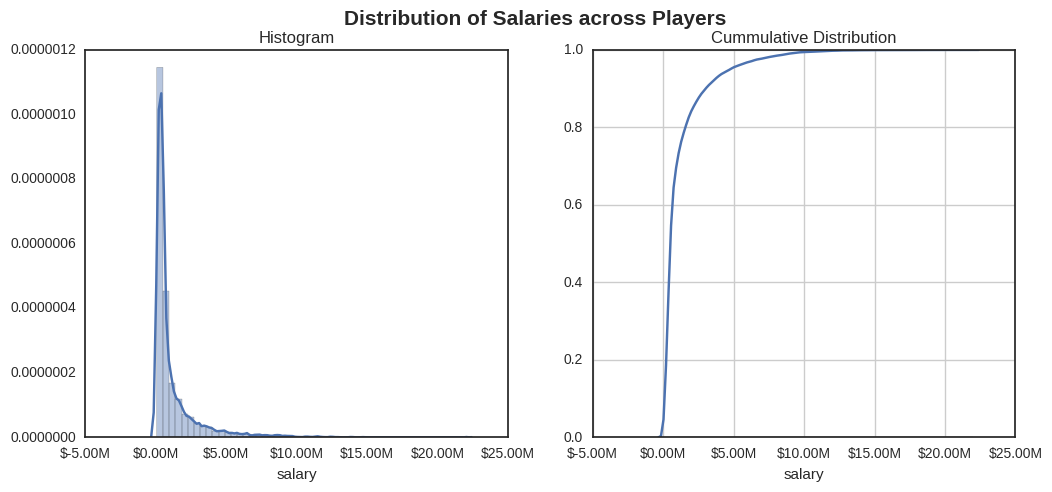

In [32]:
f, ax = plt.subplots(nrows=1, ncols=2)
f.set_size_inches((12,5))
f.suptitle("Distribution of Salaries across Players", fontsize=15, weight='bold')

p1 = sns.distplot(players_avg_salary, ax=ax[0])
p1.xaxis.set_major_formatter(formatter)
p1.set_title("Histogram")

p2 = sns.distplot(players_avg_salary, kde_kws=dict(cumulative=True), ax=ax[1])
p2.xaxis.set_major_formatter(formatter)
p2.set_title("Cummulative Distribution")
p2.grid()

In [33]:
players_avg_salary.skew()

3.4974712434125386

In [34]:
def draw_clustermap(df, fmt=None):
    # Remove ordinal columns
    non_ordinal_cols = [col for col in df.columns if col not in ['yearID', 'Rank']]

    # Compute the correlation matrix
    corr = df[non_ordinal_cols].corr()
    
    # Draw a clustermap using correlation as a distance metric
    g = sns.clustermap(corr, cmap='Spectral', linewidths=.5, metric='correlation', annot=(fmt!=None), fmt=fmt)
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.show()

### <span style="color:#2471A3">Batting metrics</span>

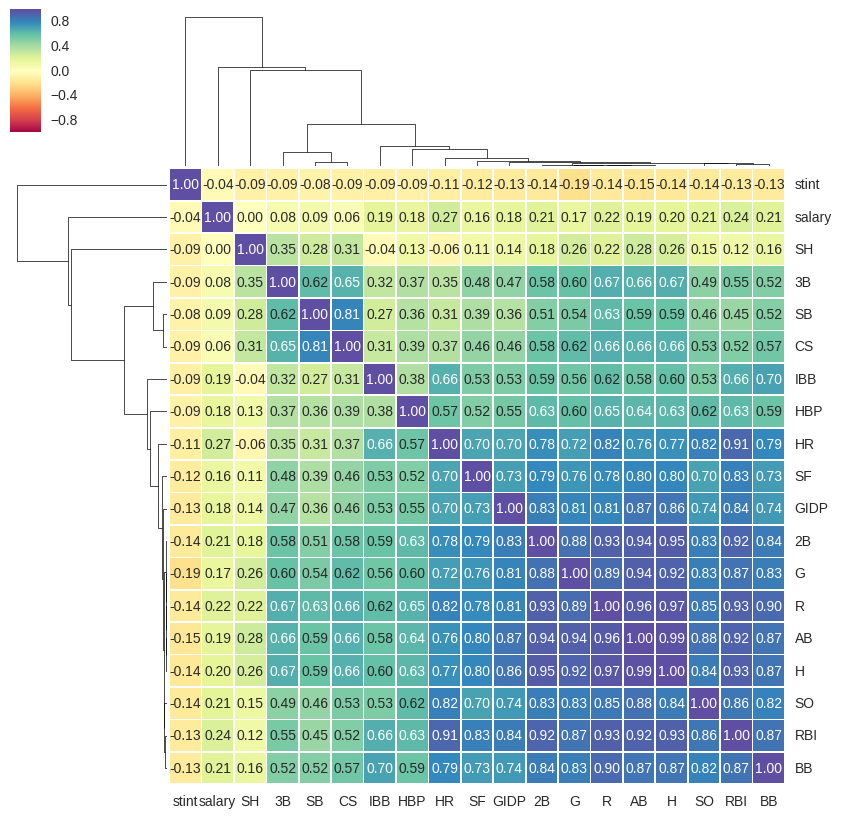

In [35]:
# Correlation clustermap of batting metrics
draw_clustermap(batting, '.2f')

The correlation heatmap suggests that higher salary correponds to high Home Runs (HR), followed by high Runs Batted In (RBI) and Runs scored (R) which is not surprising. What is surprising is that higher salary corresponds to higher Strike-Outs (SO). A closer look at the heatmap suggests that Strike-Outs are highly correlated with Home Runs $(r=0.82)$, which explains the positive correlation between salary and Strike-Outs $(r=0.21)$.

Furthermore, salary has positive correlation with Base on Balls (BB) and Doubles (2B) which is obvious as they contribute towards scoring a run. By that argument, Triples (3B) should also have equally strong correlation with salary. But the heatmap suggests a weak correlation $(r=0.08)$. This is due to the fact that triples are rare as it is difficult to keep the ball in the park and have enough time to run 270 feet. Doubles (2B) are reasonably common while singles are the most common of all. Following walks and doubles, salary has positive relationship with At-Bats (AB) and Hits (H). This is abvious, as these metrics account for opportunities created to score runs.

### <span style="color:#2471A3">Pitching metrics</span>

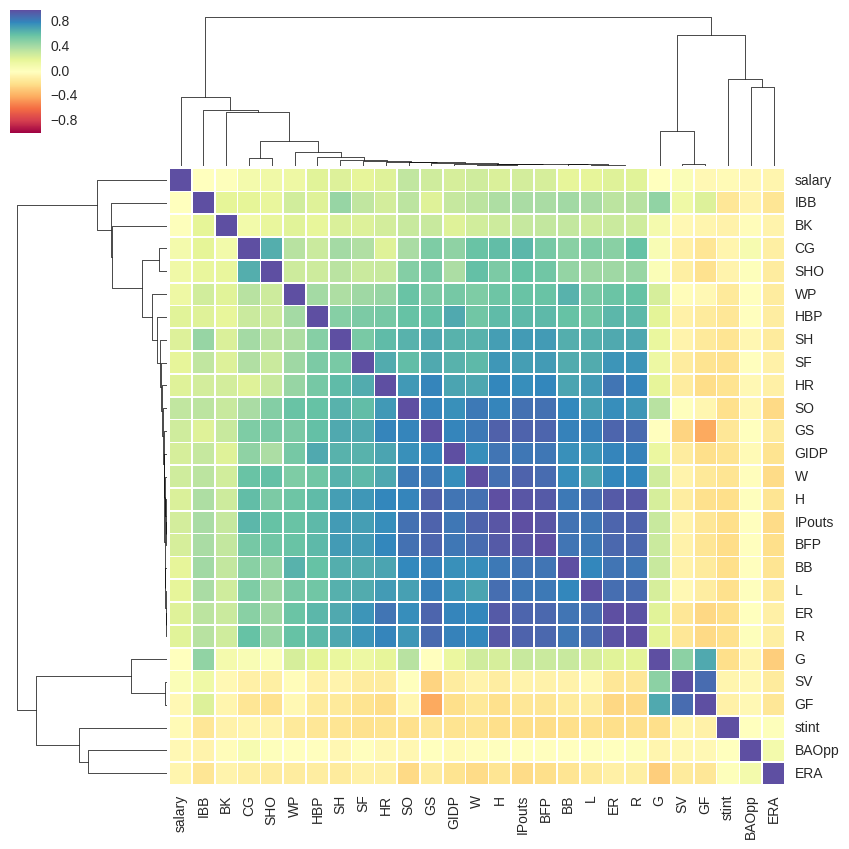

In [36]:
# Correlation clustermap of pitching metrics
draw_clustermap(pitching)

### <span style="color:#2471A3">Fielding metrics</span>

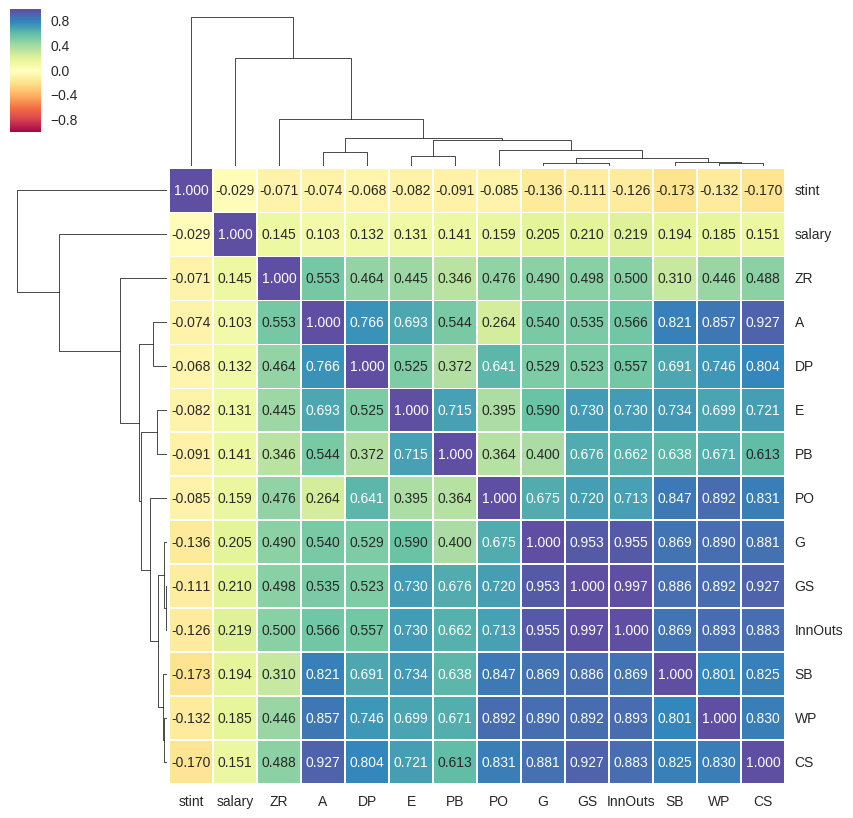

In [37]:
# Correlation clustermap of fielding statistics
draw_clustermap(fielding, '.3f')